In [31]:
import numpy as np
import yaml, os
from sys import path
from pathlib import Path
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const

path.append("opereira/starships/cc_scripts/")

import cc_scripts.reduction as red
import cc_scripts.make_model as mod
import cc_scripts.correlations as corr

from importlib import reload
# red = reload(red)

# unpack input parameters into config dictionary
config_filepath = 'config.yaml'
with open(config_filepath, 'r') as file:
    config_dict = yaml.safe_load(file)

config_dict['obs_dir'] = Path.home() / Path(config_dict['obs_dir'])

# creating the planet and observation objects
planet, obs = red.load_planet(config_dict)

# # Choose which exposures to use
# all_exposures = np.arange(obs.n_spec)
# transit_tags = np.delete(all_exposures, [20, 21, 22, 23, 31, 32, 33])  # Here we exclude the exposures [20, 21, ..., 33]

INFO:starships.planet_obs:Getting WASP-127 b from ExoFile
INFO:starships.planet_obs:Fetching the uncorrected spectra
INFO:starships.planet_obs:File: list_e2ds


Changing M_star from [2.14748266e+30] kg to 1.8889893771631484e+30 kg
It became [1.88898938e+30] kg
Changing R_star from [9.67023e+08] m to 927368100.0 m
It became [9.273681e+08] m
Changing M_pl from [3.12621121e+26] kg to 3.131905585604484e+26 kg
It became [3.13190559e+26] kg
Changing R_pl from [93726012.] m to 93726012.0 m
It became [93726012.] m
Changing RV_sys from [0.] km / s to -8.86 km / s
It became [-8.86] km / s
Changing mid_tr from [2458385.175527] d to 2459575.9239004 d
It became [2459575.9239004] d
Changing t_peri from [2458385.175527] d to 2459575.9239004 d
It became [2459575.9239004] d
Changing trandur from [15670.368] s to 4.3529 h
It became [15670.44] s
Changing period from [360984.827232] s to 4.1780625 d
It became [360984.6] s
Changing excent from 0.0 to 0.0
It became 0.0
Changing incl from [1.5393804] rad to 87.84 deg
It became [1.53309721] rad
Changing Teff from [5620.] K to 5842
It became [5842.] K
Changing Tp from [1400.] K to 1400.0 K
It became [1400.] K
Changing

INFO:starships.planet_obs:Fetching data
INFO:starships.planet_obs:File: list_tellu_corrected
INFO:starships.planet_obs:Fetching the tellurics
INFO:starships.planet_obs:File: list_tellu_recon


Transmission
Masking high variance pixels (quick fix for OH lines). 
flux_norm all nan : False
Shifting everything in the stellar ref. frame and normalizing by the median 
Spectra 
 Unberv : 74 - 55  
Telluriques 
 Unberv : 74 - 55  
flux_Sref all nan : False
Masking deep tellurics. 
flux_masked all nan : False
Building the master out #1 
ratio_filt has values <= 0.75!
flux_norm_mo all nan : False
master_out all nan : False
Building the transmission spectrum #1 
spec-trans all nan : False
Removing the static noise with PCA and sigma cliping 
(56, 75, 4088)
spec_trans all nan : False
clean_ts all nan : False
Removing the mean 
Removing the remaining high variance pixels. 

Removing the mean. 
Calculating noise with 5 PCs
/scratch/opereira/DataAnalysis/NIRPS-APERO/Reductions/WASP-127b_TEST/retrieval_input_5-pc_mask_wings90_tr1_data_info.npz
/scratch/opereira/DataAnalysis/NIRPS-APERO/Reductions/WASP-127b_TEST/retrieval_input_5-pc_mask_wings90_tr1_data_trs_0.npz


/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute `n_features_` was deprecated in version 1.2 and will be removed in 1.4. Use `n_features_in_` instead.
  warnings.warn(msg, category=FutureWarning)
INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 5 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingreturn', 'phi1', 'space']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 873]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 5 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'nonmarkingretur

TypeError: plot_steps() got an unexpected keyword argument 'path'

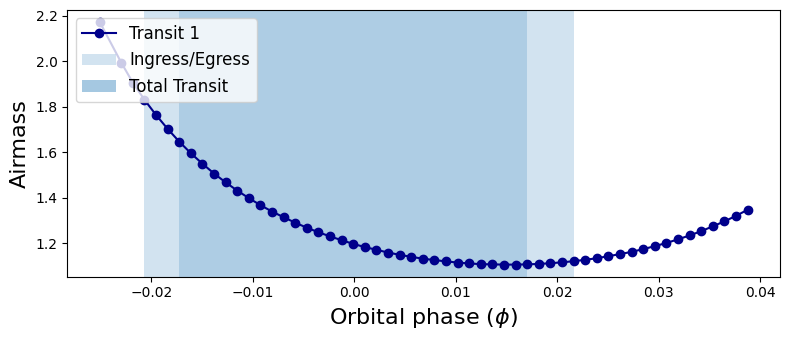

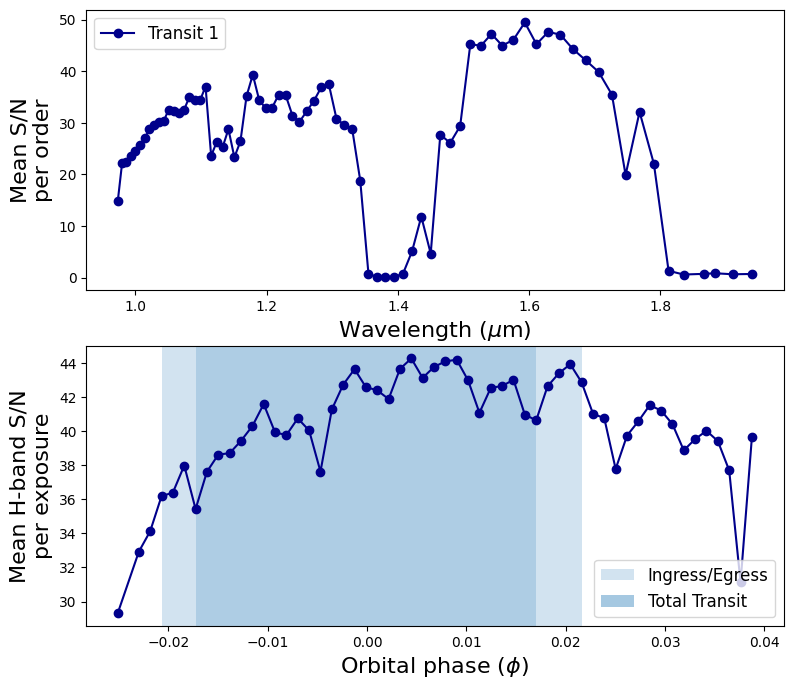

In [32]:
'''---------------------------------------Reducing the Data--------------------------------------'''

out_dir, path_fig = red.set_save_location(planet.name, config_dict['reduction'], config_dict['instrument']) # might replace with out_dir from YAML file

# building the transit spectrum
list_tr = red.build_trans_spec(config_dict, obs, planet)

# saving the transit spectrum
red.save_pl_sig(config_dict, list_tr, out_dir, do_tr = [1])

# outputting plots for reduction step
red.reduction_plots(list_tr, config_dict['idx_ord'], path_fig)

INFO:cc_scripts.make_model:Model not initialized for mode = high. Starting initialization...
INFO:starships.petitradtrans_utils:['H2O_main_iso']
/home/opereira/.venvs/starships-env/lib/python3.11/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_main_iso...
 Done.

  Read CIA opacities for H2-H2...


INFO:starships.petitradtrans_utils:Generating atmosphere with pressures from 100.0 to 1e-10
INFO:starships.petitradtrans_utils:You are not getting the individual contributions of the species
INFO:cc_scripts.make_model:Saving values in `linelist_names`.


  Read CIA opacities for H2-He...
Done.



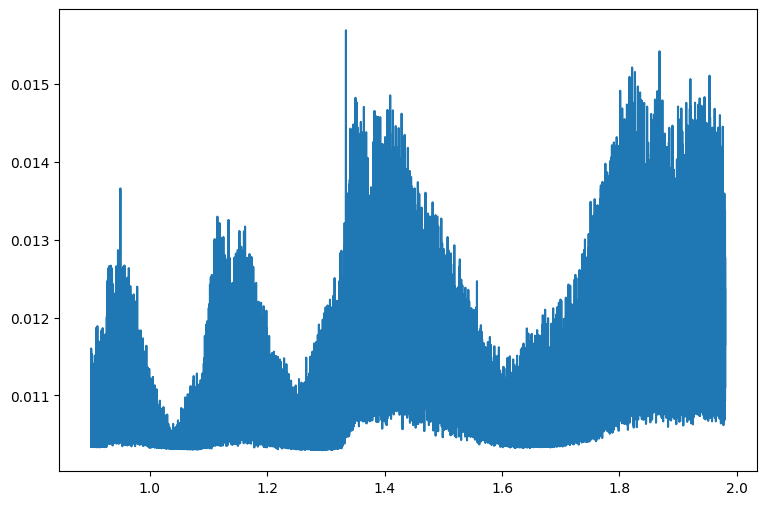

In [33]:
'''-------------------------------------Generating the Model-------------------------------------'''
mod = reload(mod)
# computing extra parameters needed for model making
int_dict = mod.create_internal_dict(config_dict, planet)

# create the model
wave_mod, mod_spec = mod.prepare_model_high_or_low(config_dict, int_dict, planet)

plt.plot(wave_mod, mod_spec)

In [34]:
'''---------------------------------Correlations---------------------------------'''
corrRV0 = np.arange(config_dict['RV_range'][0], config_dict['RV_range'][1], config_dict['RV_step'])

from starships.correlation import quick_correl
from starships.correlation_class import Correlations

# Load some model
# model_file = np.load('best_logl_model_HR.npz')
# wave_mod, model_spec = model_file['wave'], model_file['spec']

# Do the correlation
ccf = quick_correl(list_tr['1'].wave, list_tr['1'].final, corrRV, wave_mod, mod_spec, wave_ref=None, 
                     get_logl=False, kind='BL', mod2d=False, expand_mask=0, noise=None, somme=False)

In [67]:
# Create the object do make the plots and compute the different Kp

corr_obj = Correlations(ccf, kind='BL', rv_grid=corrRV, kp_array=list_tr['1'].Kp)
corr_obj.calc_ccf(orders=None, N=list_tr['1'].N_frac[None, :, None], alpha=np.ones_like(list_tr['1'].alpha_frac), index=None, ccf0=None, rm_vert_mean=False,)
corr_obj.calc_correl_snr_2d(list_tr['1'], plot=False)
corr_obj.RV_shift = np.zeros_like(list_tr['1'].alpha_frac)

# Make the plots
# corr_obj.full_plot(list_tr['1'], []) #, kind_max='grid')

TypeError: float() argument must be a string or a real number, not 'Correlations'

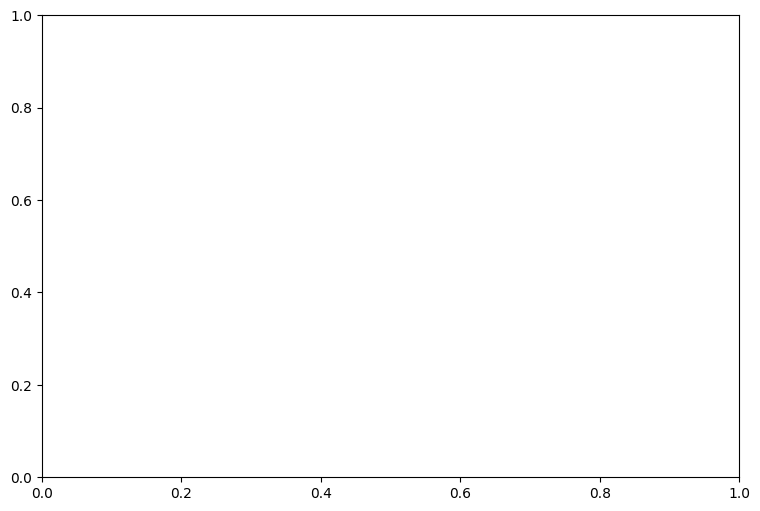

In [69]:
plt.plot(corr_obj)